<a href="https://colab.research.google.com/github/adrianweerasinghe97/SIT719/blob/master/Task_9_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Model for Predicting Indoor Locations

**Datasets**:    UJIIndoorLoc_trainingData.csv (training/validation set), UNJIndoorLoc_validationData.csv (test set)

**Scenario**:    Determine the feasbility of using Wi-Fi fingerprints indoor smartphone locationing.
             
**Goal**:        Benchmark 3 indoor locationing solutions using the UJIIndoorLoc dataset from http://archive.ics.uci.edu/ml/datasets/UJIIndoorLoc. In this script, we'll use a random forest classifier.
 
             
- Tuned random forest: "RandomForestClassifier_model.sav"
  - criterion: gini
  - max_depth: not limited
  - max_features: sqrt (The number of features to consider when 
  - looking for the best split)
  - n_estimators: 60 (number of trees in the forest)
  
             
- Tuning insights: See "tuning_rf.csv" for results of all hyperparameter combinations tried. For this dataset, the Gini splitting criterion generally performed better. Limiting the maximum depth of trees hindered performance. Using the square root of the number of features as the number of features to consider at each split was better than log2 and any percentage between 30 to 90% of the total number of features. More trees generally reduced overfitting, but increased memory usage during training considerably. Due to limited PC memory, the number of trees was limited to 60 trees in the best model.
             
             
- Reason: gives good cross-validation scores. There's slight overfitting, suggested by the 11% gap between the cross-validation scores and the average training fold scores, which can be improved if not limited by PC ram.

             
- Training set performance (average of k-folds): accuracy 0.968 kappa 0.968  

             
- Cross validation performance: accuracy 0.856 kappa 0.8554

  
- Test set performance: 

  - mean positional error 8.579 m
  - 25th percentile       1.466 m
  - 50th percentile       5.551 m
  - 75th percentile       11.218 m
  - 95th percentile       28.303 m
  - 100th percentile      94.208 m
  - Building hitrate      100%
  - Floor hitrate         90.4%

# Imports

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import glob
import math
import pickle

# Import Data

**5-anonymity**

In [55]:
# training/validation set
train_set = pd.read_csv("/content/5-anonymity.csv")

# test set
test_set = pd.read_csv("/content/ValidationData.csv")

**differential-privacy**

In [86]:
# training/validation set
train_set = pd.read_csv("/content/differential_privacy.csv")

# test set
test_set = pd.read_csv("/content/ValidationData.csv")

**delta-presence**

In [121]:
# training/validation set
train_set = pd.read_csv("/content/delta-presence.csv")

# test set
test_set = pd.read_csv("/content/ValidationData.csv")

# Evaluate Data

Training/validation Set

In [122]:
train_set.loc[train_set["BUILDINGID"] == 0]["FLOOR"].unique() # building 0 has 4 floors


array([0, 2, 1, 3])

In [123]:
train_set.loc[train_set["BUILDINGID"] == 1]["FLOOR"].unique() # building 1 has 4 floors

array([2, 0, 1, 3])

In [124]:
train_set.loc[train_set["BUILDINGID"] == 2]["FLOOR"].unique() # building 2 has 5 floors

array([3, 2, 4, 1, 0])

In [125]:
train_set.columns.values

array(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006',
       'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012',
       'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018',
       'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024',
       'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030',
       'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036',
       'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042',
       'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048',
       'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054',
       'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060',
       'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066',
       'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072',
       'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078',
       'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084',
       'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP0

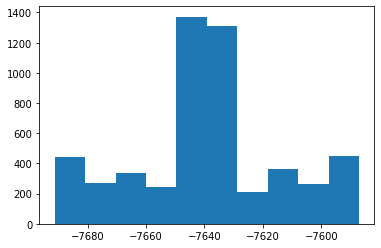

In [126]:
plt.hist(train_set.loc[train_set["BUILDINGID"] == 0]["LONGITUDE"])
plt.show()


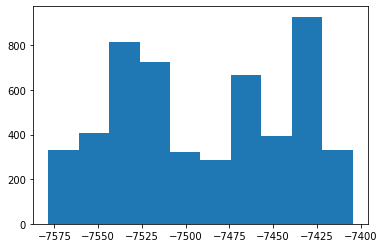

In [127]:
plt.hist(train_set.loc[train_set["BUILDINGID"] == 1]["LONGITUDE"])
plt.show()


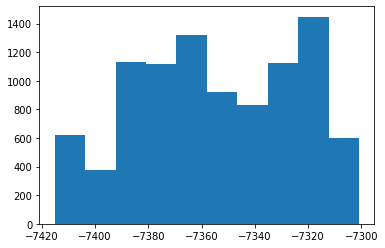

In [128]:
plt.hist(train_set.loc[train_set["BUILDINGID"] == 2]["LONGITUDE"])
plt.show()


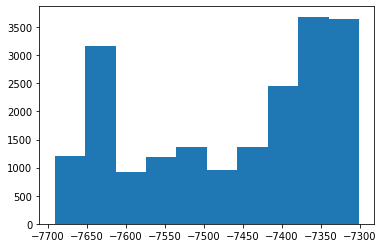

In [129]:
plt.hist(train_set["LONGITUDE"])
plt.show()


In [130]:
# check for missing values
pd.isnull(train_set)
pd.isnull(train_set).values.any()
# No missing values 

False

Test Set

In [131]:
test_set.loc[test_set["BUILDINGID"] == 0]["FLOOR"].unique() # building 0 has 4 floors

array([2, 1, 0, 3])

In [132]:
test_set.loc[test_set["BUILDINGID"] == 1]["FLOOR"].unique() # building 1 has 4 floors

array([1, 3, 2, 0])

In [133]:
test_set.loc[test_set["BUILDINGID"] == 2]["FLOOR"].unique() # building 2 has 5 floors

array([4, 2, 3, 0, 1])

In [134]:
test_set.columns.values

array(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006',
       'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012',
       'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018',
       'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024',
       'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030',
       'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036',
       'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042',
       'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048',
       'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054',
       'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060',
       'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066',
       'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072',
       'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078',
       'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084',
       'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP0

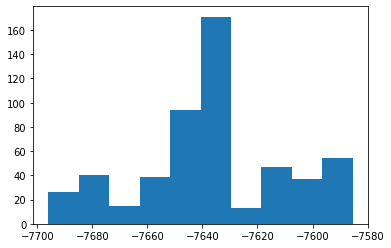

In [135]:
plt.hist(test_set.loc[test_set["BUILDINGID"] == 0]["LONGITUDE"])
plt.show()

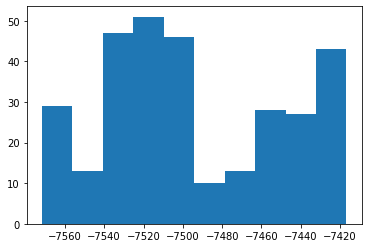

In [136]:
plt.hist(test_set.loc[test_set["BUILDINGID"] == 1]["LONGITUDE"])
plt.show()

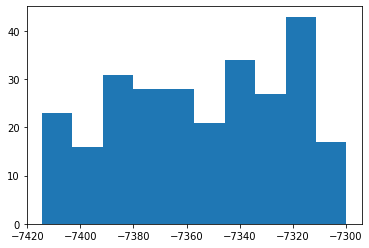

In [137]:
plt.hist(test_set.loc[test_set["BUILDINGID"] == 2]["LONGITUDE"])
plt.show()

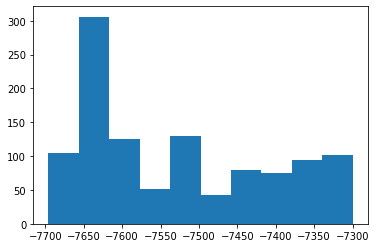

In [138]:
plt.hist(test_set["LONGITUDE"])
plt.show()

In [104]:
# check for missing values
pd.isnull(test_set)
pd.isnull(test_set).values.any()
# No missing values

False

# Preprocess Data and Feature Engineering

Training/validation Set

In [ ]:
# Fingerprint data representation: positive-value representation for all WAPs.
# Original representation: -104 to 0 (weak to strong), 100 for no signal.
# New represenation: 1 to 105 (weak to strong), 0 for no signal.
train_set.iloc[:, 0:520].min().min() # minimum WAP is -104 dBm
train_set_P = train_set.copy()
train_set_P.iloc[:, 0:520] = np.where(train_set_P.iloc[:, 0:520] <= 0, 
                train_set_P.iloc[:, 0:520] + 105, 
                train_set_P.iloc[:, 0:520] - 100) 

In [107]:

combined = pd.concat([train_set_P, test_set]) 
combined = combined.assign(UNIQUELOCATION = (combined['LONGITUDE'].astype(str) + '_' + combined['LATITUDE'].astype(str) + '_' + combined['FLOOR'].astype(str) + '_' + combined['BUILDINGID'].astype(str)).astype('category').cat.codes)
len(combined["UNIQUELOCATION"].unique()) # 1995 unique locations

1997

In [108]:
# split again
train_set_PU = combined.iloc[0:19937, :]
test_set_U = combined.iloc[19937:21048, :]

In [109]:
# Change variable types
train_set_PU["UNIQUELOCATION"] = train_set_PU["UNIQUELOCATION"].astype("category")
train_set_PU.dtypes

WAP001                object
WAP002                 int64
WAP003                 int64
WAP004                 int64
WAP005                 int64
                      ...   
RELATIVEPOSITION       int64
USERID                 int64
PHONEID                int64
TIMESTAMP              int64
UNIQUELOCATION      category
Length: 530, dtype: object

In [110]:
X_train = train_set_PU.iloc[:, 0:520]
y_train = train_set_PU.iloc[:, 520:530]

Test Set

In [111]:
# Fingerprint data representation
test_set_PU = test_set_U.copy()
test_set_PU.iloc[:, 0:520] = np.where(test_set_PU.iloc[:, 0:520] <= 0, test_set_PU.iloc[:, 0:520] + 105, test_set_PU.iloc[:, 0:520] - 100) 

In [112]:
test_set_PU["UNIQUELOCATION"] = test_set_PU["UNIQUELOCATION"].astype("category")
test_set_PU.dtypes

WAP001               float64
WAP002               float64
WAP003               float64
WAP004               float64
WAP005               float64
                      ...   
RELATIVEPOSITION       int64
USERID                 int64
PHONEID                int64
TIMESTAMP              int64
UNIQUELOCATION      category
Length: 530, dtype: object

In [113]:
X_test = test_set_PU.iloc[:, 0:520]
y_test = test_set_PU.iloc[:, 520:530]

In [114]:
# Create a reference table for looking up the LONGITUDE, LATITUDE, FLOOR, and 
# BUILDINGID associated with each UNIQUELOCATION value.
ref_table = pd.concat([y_train.iloc[:, [0,1,2,3,9]], y_test.iloc[:, [0,1,2,3,9]]])
ref_table = ref_table.drop_duplicates()

In [115]:
#--- save data ---#
def save_data(dataframe, filename):
    file_present = glob.glob(filename) # boolean, file already present?
    if not file_present:
        dataframe.to_csv(filename)
    else:
        print('WARNING: This file already exists.')

5-anonymity

In [32]:
save_data(X_train, 'X_train_rf(5-anonymity).csv')
save_data(y_train, 'y_train_rf(5-anonymity).csv')
save_data(X_test, 'X_test_rf(5-anonymity).csv')
save_data(y_test, 'y_test_rf(5-anonymity).csv')

**differential-privacy**

In [116]:
save_data(X_train, 'X_train_rf(differential-privacy).csv')
save_data(y_train, 'y_train_rf(differential-privacy).csv')
save_data(X_test, 'X_test_rf(differential-privacy).csv')
save_data(y_test, 'y_test_rf(differential-privacy).csv')

**delta-presence**

In [ ]:
save_data(X_train, 'X_train_rf(delta-presence).csv')
save_data(y_train, 'y_train_rf(delta-presence).csv')
save_data(X_test, 'X_test_rf(delta-presence).csv')
save_data(y_test, 'y_test_rf(delta-presence).csv')

**5-anonymity**

In [33]:
# --- load data ---
X_train = pd.read_csv('/content/X_train_rf(5-anonymity).csv', index_col = 0)
y_train = pd.read_csv('/content/y_train_rf(5-anonymity).csv', index_col = 0)
X_test = pd.read_csv('/content/X_test_rf(5-anonymity).csv', index_col = 0)
y_test = pd.read_csv('/content/y_test_rf(5-anonymity).csv', index_col = 0)

**differential-privacy**

In [117]:
# --- load data ---
X_train = pd.read_csv('/content/X_train_rf(differential-privacy).csv', index_col = 0)
y_train = pd.read_csv('/content/y_train_rf(differential-privacy).csv', index_col = 0)
X_test = pd.read_csv('/content/X_test_rf(differential-privacy).csv', index_col = 0)
y_test = pd.read_csv('/content/y_test_rf(differential-privacy).csv', index_col = 0)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**delta-presence**

In [ ]:
# --- load data ---
X_train = pd.read_csv('/content/X_train_rf(5-anonymity).csv', index_col = 0)
y_train = pd.read_csv('/content/y_train_rf(5-anonymity).csv', index_col = 0)
X_test = pd.read_csv('/content/X_test_rf(5-anonymity).csv', index_col = 0)
y_test = pd.read_csv('/content/y_test_rf(5-anonymity).csv', index_col = 0)

In [118]:
#-- delete unneeded datasets created during preprocessing to free up memory --#
del train_set, train_set_P, train_set_PU, test_set, test_set_U, test_set_PU, combined

# Train Model(s)

1. Random Forest

In [ ]:
if __name__ == '__main__':
    

    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier(random_state = 0)
    

    from sklearn.model_selection import GridSearchCV
    
    # hyperparameters: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    
    hyperparameters = {'criterion': ['gini'], 
                  'max_depth': [None], 
                  'max_features': ['sqrt'],
                  'n_estimators': [60]}
    
    from sklearn.metrics import cohen_kappa_score
    from sklearn.metrics import make_scorer
    scoring = {'accuracy': 'accuracy',
               'kappa': make_scorer(cohen_kappa_score)}
    
    grid = GridSearchCV(estimator = classifier, param_grid = hyperparameters, scoring = scoring, cv = 2, refit = 'accuracy', return_train_score = True, n_jobs = -1) 
    
    tic = time.time()
    grid_result = grid.fit(X_train, y_train.iloc[:, 9].squeeze()) 
    toc = time.time()
    run_time = (toc - tic)/60
    import winsound; winsound.Beep(frequency = 1500, duration = 2000) 

In [ ]:
#--- cross validation metrics and training set metrics (average of folds) ----#
cv_results_ = pd.DataFrame.from_dict(grid_result.cv_results_) 
cv_results_.insert(loc = 0, column = 'Model', 
                   value = ['RandomForestClassifier']*cv_results_.shape[0])
cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                   value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                   value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
with open('tuning_rf.csv', 'a') as f:
    cv_results_.to_csv(f, header = True)

In [ ]:
grid_result.best_estimator_
grid_result.best_score_
grid_result.best_params_

In [ ]:
#--- save best model ---#

def save_model(model, model_name):
   model_name_present = glob.glob(model_name) # boolean
   if not model_name_present:
       pickle.dump(grid_result, open(model_name, 'wb'))
   else:
       print('WARNING: This file already exists.')

**save model for 5-anonymity**

In [ ]:
save_model(grid_result, 'RandomForestClassifier_model(5-anonymity).sav')

**save model for differential-privacy**

In [ ]:
save_model(grid_result, 'RandomForestClassifier_model(differential-privacy).sav')

**save model for delta-presence**

In [ ]:
save_model(grid_result, 'RandomForestClassifier_model(delta-presence).sav')

**Load model for 5-anonymity**

In [ ]:
#--- load model ---#
grid_result = pickle.load(open('RandomForestClassifier_model.sav(5-anonymity)', 'rb'))

**Load model for differential-privacy**

In [ ]:
#--- load model ---#
grid_result = pickle.load(open('RandomForestClassifier_model.sav(differential-privacy)', 'rb'))

**Load model for delta-presence**

In [ ]:
#--- load model ---#
grid_result = pickle.load(open('RandomForestClassifier_model.sav(delta-presence)', 'rb'))

In [ ]:
#--- test set metrics ---#
y_pred = grid_result.predict(X_test)
np.mean(y_pred == y_test.iloc[:, 9])


In [ ]:
y_test_pos = y_test.iloc[:, 0:2].values 
y_test_floor = y_test.iloc[:, 2].values
y_test_building = y_test.iloc[:, 3].values

dict_loc = {}
m_total = ref_table.shape[0]
for i in range(m_total):
    key = int(ref_table.iloc[i]['UNIQUELOCATION'])
    value = ref_table.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos = np.asarray([dict_loc[i] for i in y_pred])[:, 0:2] 
y_pred_floor = np.asarray([dict_loc[i] for i in y_pred])[:, 2]
y_pred_building = np.asarray([dict_loc[i] for i in y_pred])[:, 3]

In [ ]:
def euclidean(y_test_pos, y_pred_pos):
    
    m_test = y_test_pos.shape[0]
    D_error = np.sum((y_test_pos - y_pred_pos)**2, axis = 1)**0.5
    
    return D_error

In [ ]:
D_error = euclidean(y_test_pos, y_pred_pos)
# sorted   
sorted_D_error = sorted(D_error)

m_test = y_test.shape[0]
mean_error = np.mean(D_error) 
percentile_25th = sorted_D_error[math.ceil(m_test*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error[math.ceil(m_test*0.50) - 1] # meters
percentile_75th = sorted_D_error[math.ceil(m_test*0.75) - 1] # meters
percentile_95th = sorted_D_error[math.ceil(m_test*0.95) - 1] # meters
percentile_100th = sorted_D_error[math.ceil(m_test*1.00) - 1] # meters
building_hitrate = np.mean(y_test_building == y_pred_building)
floor_hitrate = np.mean(y_test_floor == y_pred_floor)

In [ ]:
mean_error = np.mean(D_error) 

**2. Decision Tree**

In [ ]:
if __name__ == '__main__':
    
    from sklearn.tree import DecisionTreeClassifier

    classifier = DecisionTreeClassifier(random_state = 0)
    

    from sklearn.model_selection import GridSearchCV
        
    hyperparameters = {'criterion': ['gini'], 
                  'max_depth': [None], 
                  'max_features': ['sqrt'],
                  'n_estimators': [60]}
    
    from sklearn.metrics import cohen_kappa_score
    from sklearn.metrics import make_scorer
    scoring = {'accuracy': 'accuracy',
               'kappa': make_scorer(cohen_kappa_score)}
    
    grid = GridSearchCV(estimator = classifier, param_grid = hyperparameters, scoring = scoring, cv = 2, refit = 'accuracy', return_train_score = True, n_jobs = -1) 
    
    tic = time.time()
    grid_result = grid.fit(X_train, y_train.iloc[:, 9].squeeze()) 
    toc = time.time()
    run_time = (toc - tic)/60
    import winsound; winsound.Beep(frequency = 1500, duration = 2000) 

In [ ]:
#--- cross validation metrics and training set metrics (average of folds) ----#
cv_results_ = pd.DataFrame.from_dict(grid_result.cv_results_) 
cv_results_.insert(loc = 0, column = 'Model', 
                   value = ['DecisionTreeClassifier']*cv_results_.shape[0])
cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                   value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                   value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
with open('tuning_rf.csv', 'a') as f:
    cv_results_.to_csv(f, header = True)

In [ ]:
grid_result.best_estimator_
grid_result.best_score_
grid_result.best_params_

In [ ]:
#--- save best model ---#

def save_model(model, model_name):
   model_name_present = glob.glob(model_name) # boolean
   if not model_name_present:
       pickle.dump(grid_result, open(model_name, 'wb'))
   else:
       print('WARNING: This file already exists.')

**save model for 5-anonymity**

In [ ]:
save_model(grid_result, 'DecisionTreeClassifier_model(5-anonymity).sav')

**save model for differential-privacy**

In [ ]:
save_model(grid_result, 'DecisionTreeClassifier_model(differential-privacy).sav')

**save model for delta-presence**

In [ ]:
save_model(grid_result, 'RDecisionTreeClassifier_model(delta-presence).sav')

**Load model for 5-anonymity**

In [ ]:
#--- load model ---#
grid_result = pickle.load(open('DecisionTreeClassifier_model.sav(5-anonymity)', 'rb'))

**Load model for differential-privacy**

In [ ]:
#--- load model ---#
grid_result = pickle.load(open('DecisionTreeClassifier_model.sav(differential-privacy)', 'rb'))

**Load model for delta-presence**

In [ ]:
#--- load model ---#
grid_result = pickle.load(open('DecisionTreeClassifier_model.sav(delta-presence)', 'rb'))

In [ ]:
#--- test set metrics ---#
y_pred = grid_result.predict(X_test)
np.mean(y_pred == y_test.iloc[:, 9])


In [ ]:
y_test_pos = y_test.iloc[:, 0:2].values 
y_test_floor = y_test.iloc[:, 2].values
y_test_building = y_test.iloc[:, 3].values

dict_loc = {}
m_total = ref_table.shape[0]
for i in range(m_total):
    key = int(ref_table.iloc[i]['UNIQUELOCATION'])
    value = ref_table.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos = np.asarray([dict_loc[i] for i in y_pred])[:, 0:2] 
y_pred_floor = np.asarray([dict_loc[i] for i in y_pred])[:, 2]
y_pred_building = np.asarray([dict_loc[i] for i in y_pred])[:, 3]

In [ ]:
def euclidean(y_test_pos, y_pred_pos):
    
    m_test = y_test_pos.shape[0]
    D_error = np.sum((y_test_pos - y_pred_pos)**2, axis = 1)**0.5
    
    return D_error

In [ ]:
D_error = euclidean(y_test_pos, y_pred_pos)
# sorted   
sorted_D_error = sorted(D_error)

m_test = y_test.shape[0]
mean_error = np.mean(D_error) 
percentile_25th = sorted_D_error[math.ceil(m_test*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error[math.ceil(m_test*0.50) - 1] # meters
percentile_75th = sorted_D_error[math.ceil(m_test*0.75) - 1] # meters
percentile_95th = sorted_D_error[math.ceil(m_test*0.95) - 1] # meters
percentile_100th = sorted_D_error[math.ceil(m_test*1.00) - 1] # meters
building_hitrate = np.mean(y_test_building == y_pred_building)
floor_hitrate = np.mean(y_test_floor == y_pred_floor)

In [ ]:
mean_error = np.mean(D_error) 

**3. Naive Bayes**

In [ ]:
if __name__ == '__main__':
    
    from sklearn.naive_bayes import GaussianNB
    from sklearn.model_selection import GridSearchCV

    param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

    classifier = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
    

    from sklearn.model_selection import GridSearchCV
        
    hyperparameters = {'criterion': ['gini'], 
                  'max_depth': [None], 
                  'max_features': ['sqrt'],
                  'n_estimators': [60]}
    
    from sklearn.metrics import cohen_kappa_score
    from sklearn.metrics import make_scorer
    scoring = {'accuracy': 'accuracy',
               'kappa': make_scorer(cohen_kappa_score)}
    
    grid = GridSearchCV(estimator = classifier, param_grid = hyperparameters, scoring = scoring, cv = 2, refit = 'accuracy', return_train_score = True, n_jobs = -1) 
    
    tic = time.time()
    grid_result = grid.fit(X_train, y_train.iloc[:, 9].squeeze()) 
    toc = time.time()
    run_time = (toc - tic)/60
    import winsound; winsound.Beep(frequency = 1500, duration = 2000) 

In [ ]:
#--- cross validation metrics and training set metrics (average of folds) ----#
cv_results_ = pd.DataFrame.from_dict(grid_result.cv_results_) 
cv_results_.insert(loc = 0, column = 'Model', 
                   value = ['GaussianNB']*cv_results_.shape[0])
cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                   value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                   value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
with open('tuning_rf.csv', 'a') as f:
    cv_results_.to_csv(f, header = True)

In [ ]:
grid_result.best_estimator_
grid_result.best_score_
grid_result.best_params_

In [ ]:
#--- save best model ---#

def save_model(model, model_name):
   model_name_present = glob.glob(model_name) # boolean
   if not model_name_present:
       pickle.dump(grid_result, open(model_name, 'wb'))
   else:
       print('WARNING: This file already exists.')

**save model for 5-anonymity**

In [ ]:
save_model(grid_result, 'NaiveBayes_model(5-anonymity).sav')

**save model for differential-privacy**

In [ ]:
save_model(grid_result, 'NaiveBayes_model(differential-privacy).sav')

**save model for delta-presence**

In [ ]:
save_model(grid_result, 'NaiveBayes_model(delta-presence).sav')

**Load model for 5-anonymity**

In [ ]:
#--- load model ---#
grid_result = pickle.load(open('NaiveBayes_model.sav(5-anonymity)', 'rb'))

**Load model for differential-privacy**

In [ ]:
#--- load model ---#
grid_result = pickle.load(open('NaiveBayes_model.sav(differential-privacy)', 'rb'))

**Load model for delta-presence**

In [ ]:
#--- load model ---#
grid_result = pickle.load(open('NaiveBayes_model.sav(delta-presence)', 'rb'))

In [ ]:
#--- test set metrics ---#
y_pred = grid_result.predict(X_test)
np.mean(y_pred == y_test.iloc[:, 9])


In [ ]:
y_test_pos = y_test.iloc[:, 0:2].values 
y_test_floor = y_test.iloc[:, 2].values
y_test_building = y_test.iloc[:, 3].values

dict_loc = {}
m_total = ref_table.shape[0]
for i in range(m_total):
    key = int(ref_table.iloc[i]['UNIQUELOCATION'])
    value = ref_table.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos = np.asarray([dict_loc[i] for i in y_pred])[:, 0:2] 
y_pred_floor = np.asarray([dict_loc[i] for i in y_pred])[:, 2]
y_pred_building = np.asarray([dict_loc[i] for i in y_pred])[:, 3]

In [ ]:
def euclidean(y_test_pos, y_pred_pos):
    
    m_test = y_test_pos.shape[0]
    D_error = np.sum((y_test_pos - y_pred_pos)**2, axis = 1)**0.5
    
    return D_error

In [ ]:
D_error = euclidean(y_test_pos, y_pred_pos)
# sorted   
sorted_D_error = sorted(D_error)

m_test = y_test.shape[0]
mean_error = np.mean(D_error) 
percentile_25th = sorted_D_error[math.ceil(m_test*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error[math.ceil(m_test*0.50) - 1] # meters
percentile_75th = sorted_D_error[math.ceil(m_test*0.75) - 1] # meters
percentile_95th = sorted_D_error[math.ceil(m_test*0.95) - 1] # meters
percentile_100th = sorted_D_error[math.ceil(m_test*1.00) - 1] # meters
building_hitrate = np.mean(y_test_building == y_pred_building)
floor_hitrate = np.mean(y_test_floor == y_pred_floor)

In [ ]:
mean_error = np.mean(D_error) 

**4. Logistic Regression**

In [ ]:
if __name__ == '__main__':
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import GridSearchCV

    param_grid_lr = {
    'max_iter': [20, 50, 100, 200, 500, 1000],                      
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],   
    'class_weight': ['balanced']   
}

    classifier = GridSearchCV(estimator=LogisticRegression(random_state=1000), param_grid=param_grid_lr, verbose=1, cv=5, n_jobs=-1)
    

    from sklearn.model_selection import GridSearchCV
        
    hyperparameters = {'criterion': ['gini'], 
                  'max_depth': [None], 
                  'max_features': ['sqrt'],
                  'n_estimators': [60]}
    
    from sklearn.metrics import cohen_kappa_score
    from sklearn.metrics import make_scorer
    scoring = {'accuracy': 'accuracy',
               'kappa': make_scorer(cohen_kappa_score)}
    
    grid = GridSearchCV(estimator = classifier, param_grid = hyperparameters, scoring = scoring, cv = 2, refit = 'accuracy', return_train_score = True, n_jobs = -1) 
    
    tic = time.time()
    grid_result = grid.fit(X_train, y_train.iloc[:, 9].squeeze()) 
    toc = time.time()
    run_time = (toc - tic)/60
    import winsound; winsound.Beep(frequency = 1500, duration = 2000) 

In [ ]:
#--- cross validation metrics and training set metrics (average of folds) ----#
cv_results_ = pd.DataFrame.from_dict(grid_result.cv_results_) 
cv_results_.insert(loc = 0, column = 'Model', 
                   value = ['LogisticRegression']*cv_results_.shape[0])
cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                   value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                   value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
with open('tuning_rf.csv', 'a') as f:
    cv_results_.to_csv(f, header = True)

In [ ]:
grid_result.best_estimator_
grid_result.best_score_
grid_result.best_params_

In [ ]:
#--- save best model ---#

def save_model(model, model_name):
   model_name_present = glob.glob(model_name) # boolean
   if not model_name_present:
       pickle.dump(grid_result, open(model_name, 'wb'))
   else:
       print('WARNING: This file already exists.')

**save model for 5-anonymity**

In [ ]:
save_model(grid_result, 'LogisticRegression_model(5-anonymity).sav')

**save model for differential-privacy**

In [ ]:
save_model(grid_result, 'LogisticRegression_model(differential-privacy).sav')

**save model for delta-presence**

In [ ]:
save_model(grid_result, 'LogisticRegression_model(delta-presence).sav')

**Load model for 5-anonymity**

In [ ]:
#--- load model ---#
grid_result = pickle.load(open('LogisticRegression_model.sav(5-anonymity)', 'rb'))

**Load model for differential-privacy**

In [ ]:
#--- load model ---#
grid_result = pickle.load(open('LogisticRegression_model.sav(differential-privacy)', 'rb'))

**Load model for delta-presence**

In [ ]:
#--- load model ---#
grid_result = pickle.load(open('LogisticRegression_model.sav(delta-presence)', 'rb'))

In [ ]:
#--- test set metrics ---#
y_pred = grid_result.predict(X_test)
np.mean(y_pred == y_test.iloc[:, 9])


In [ ]:
y_test_pos = y_test.iloc[:, 0:2].values 
y_test_floor = y_test.iloc[:, 2].values
y_test_building = y_test.iloc[:, 3].values

dict_loc = {}
m_total = ref_table.shape[0]
for i in range(m_total):
    key = int(ref_table.iloc[i]['UNIQUELOCATION'])
    value = ref_table.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos = np.asarray([dict_loc[i] for i in y_pred])[:, 0:2] 
y_pred_floor = np.asarray([dict_loc[i] for i in y_pred])[:, 2]
y_pred_building = np.asarray([dict_loc[i] for i in y_pred])[:, 3]

In [ ]:
def euclidean(y_test_pos, y_pred_pos):
    
    m_test = y_test_pos.shape[0]
    D_error = np.sum((y_test_pos - y_pred_pos)**2, axis = 1)**0.5
    
    return D_error

In [ ]:
D_error = euclidean(y_test_pos, y_pred_pos)
# sorted   
sorted_D_error = sorted(D_error)

m_test = y_test.shape[0]
mean_error = np.mean(D_error) 
percentile_25th = sorted_D_error[math.ceil(m_test*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error[math.ceil(m_test*0.50) - 1] # meters
percentile_75th = sorted_D_error[math.ceil(m_test*0.75) - 1] # meters
percentile_95th = sorted_D_error[math.ceil(m_test*0.95) - 1] # meters
percentile_100th = sorted_D_error[math.ceil(m_test*1.00) - 1] # meters
building_hitrate = np.mean(y_test_building == y_pred_building)
floor_hitrate = np.mean(y_test_floor == y_pred_floor)

In [ ]:
mean_error = np.mean(D_error) 

**5. Multi-Layer Perceptron**

In [ ]:
if __name__ == '__main__':
    
    from sklearn.neural_network import MLPClassifier


    classifier = MLPClassifier(random_state = 17)
    

    from sklearn.model_selection import GridSearchCV
        
    hyperparameters = {'criterion': ['gini'], 
                  'max_depth': [None], 
                  'max_features': ['sqrt'],
                  'n_estimators': [60]}
    
    from sklearn.metrics import cohen_kappa_score
    from sklearn.metrics import make_scorer
    scoring = {'accuracy': 'accuracy',
               'kappa': make_scorer(cohen_kappa_score)}
    
    grid = GridSearchCV(estimator = classifier, param_grid = hyperparameters, scoring = scoring, cv = 2, refit = 'accuracy', return_train_score = True, n_jobs = -1) 
    
    tic = time.time()
    grid_result = grid.fit(X_train, y_train.iloc[:, 9].squeeze()) 
    toc = time.time()
    run_time = (toc - tic)/60
    import winsound; winsound.Beep(frequency = 1500, duration = 2000) 

In [ ]:
#--- cross validation metrics and training set metrics (average of folds) ----#
cv_results_ = pd.DataFrame.from_dict(grid_result.cv_results_) 
cv_results_.insert(loc = 0, column = 'Model', 
                   value = ['MLPClassifier']*cv_results_.shape[0])
cv_results_.insert(loc = 28, column = 'mean train - cross_val accuracy',  # loc = 60 if you use cv=10
                   value = cv_results_['mean_train_accuracy'] - cv_results_['mean_test_accuracy'])
cv_results_.insert(loc = 29, column = 'mean train - cross_val kappa',   # loc = 61 if you use cv=10
                   value = cv_results_['mean_train_kappa'] - cv_results_['mean_test_kappa'])
with open('tuning_rf.csv', 'a') as f:
    cv_results_.to_csv(f, header = True)

In [ ]:
grid_result.best_estimator_
grid_result.best_score_
grid_result.best_params_

In [ ]:
#--- save best model ---#

def save_model(model, model_name):
   model_name_present = glob.glob(model_name) # boolean
   if not model_name_present:
       pickle.dump(grid_result, open(model_name, 'wb'))
   else:
       print('WARNING: This file already exists.')

**save model for 5-anonymity**

In [ ]:
save_model(grid_result, 'MLPClassifier_model(5-anonymity).sav')

**save model for differential-privacy**

In [ ]:
save_model(grid_result, 'MLPClassifier_model(differential-privacy).sav')

**save model for delta-presence**

In [ ]:
save_model(grid_result, 'MLPClassifier_model(delta-presence).sav')

**Load model for 5-anonymity**

In [ ]:
#--- load model ---#
grid_result = pickle.load(open('MLPClassifier_model.sav(5-anonymity)', 'rb'))

**Load model for differential-privacy**

In [ ]:
#--- load model ---#
grid_result = pickle.load(open('MLPClassifier_model.sav(differential-privacy)', 'rb'))

**Load model for delta-presence**

In [ ]:
#--- load model ---#
grid_result = pickle.load(open('MLPClassifier_model.sav(delta-presence)', 'rb'))

In [ ]:
#--- test set metrics ---#
y_pred = grid_result.predict(X_test)
np.mean(y_pred == y_test.iloc[:, 9])


In [ ]:
y_test_pos = y_test.iloc[:, 0:2].values 
y_test_floor = y_test.iloc[:, 2].values
y_test_building = y_test.iloc[:, 3].values

dict_loc = {}
m_total = ref_table.shape[0]
for i in range(m_total):
    key = int(ref_table.iloc[i]['UNIQUELOCATION'])
    value = ref_table.iloc[i, 0:4].values
    dict_loc[key] = value

y_pred_pos = np.asarray([dict_loc[i] for i in y_pred])[:, 0:2] 
y_pred_floor = np.asarray([dict_loc[i] for i in y_pred])[:, 2]
y_pred_building = np.asarray([dict_loc[i] for i in y_pred])[:, 3]

In [ ]:
def euclidean(y_test_pos, y_pred_pos):
    
    m_test = y_test_pos.shape[0]
    D_error = np.sum((y_test_pos - y_pred_pos)**2, axis = 1)**0.5
    
    return D_error

In [ ]:
D_error = euclidean(y_test_pos, y_pred_pos)
# sorted   
sorted_D_error = sorted(D_error)

m_test = y_test.shape[0]
mean_error = np.mean(D_error) 
percentile_25th = sorted_D_error[math.ceil(m_test*0.25) - 1] # -1 since 0-indexed. meters
percentile_50th = sorted_D_error[math.ceil(m_test*0.50) - 1] # meters
percentile_75th = sorted_D_error[math.ceil(m_test*0.75) - 1] # meters
percentile_95th = sorted_D_error[math.ceil(m_test*0.95) - 1] # meters
percentile_100th = sorted_D_error[math.ceil(m_test*1.00) - 1] # meters
building_hitrate = np.mean(y_test_building == y_pred_building)
floor_hitrate = np.mean(y_test_floor == y_pred_floor)

In [ ]:
mean_error = np.mean(D_error) 